#EE452 Computer Vision: Assignment 1
Training Neural Networks for Image Classification
# Owais Aijaz 07610

# Loading the Dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"owaisaijaz","key":"c4452ab5b5572b72ea8352993f3bbaca"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 346M/346M [00:17<00:00, 23.3MB/s]
100% 346M/346M [00:17<00:00, 20.8MB/s]


In [ ]:
!unzip /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

# Question 01

The Intel Image Classification Dataset is a publicly available dataset provided by Intel for image classification tasks. It consists of approximately 25,000 images size 150x150 categorized into six classes:
Dataset Constituents:
Buildings (4,582 images)
Forest (3,186 images)
Glacier (3,151 images)
Mountain (4,071 images)
Sea (4,446 images)
Street (5,464 images)
The images are in JPEG format. There are around 14k images in Train, 3k in Test and 7k in Prediction.


Preprocessing Steps for Image Data:
1. Data Cleaning
Handling missing or corrupted images
Removing duplicates or near-duplicates
Checking for inconsistent or incorrect labels
2. Data Augmentation
Rotation (e.g., 90, 180, 270 degrees)
Flipping (horizontal and vertical)
Scaling (resize, zoom, or crop)
Color jittering (brightness, contrast, saturation)
Noise injection (Gaussian, salt and pepper)
3. Image Normalization
Scaling pixel values to a common range (e.g., 0-1 or -1 to 1)
Normalizing histograms for contrast consistency
4. Data Transformation
Converting images to grayscale or other color spaces (e.g., YUV, HSV)
Applying filters (e.g., Gaussian blur, median blur)
5. Image Segmentation (if necessary)
Object detection and isolation
Region of interest (ROI) extraction

# Question 02

In [ ]:
import numpy as np

def filt(input_image, filter_kernel, padding=True, normalization=True):
    #Determining the grayscale or color image
    if input_image.ndim == 3:
        height, width, channels = input_image.shape
    elif input_image.ndim == 2:
        height, width = input_image.shape
        channels = 1
        input_image = input_image[:, :, np.newaxis]  #Convert to (H, W, 1) for consistency
    else:
        raise ValueError("Input image must be a 2D or 3D numpy array.")

    #Filter dimensions
    filter_height, filter_width = filter_kernel.shape
    pad_height = filter_height // 2
    pad_width = filter_width // 2

    #Normalizing the filter kernel
    if normalization:
        filter_sum = np.sum(filter_kernel)
        if filter_sum != 0:
            filter_kernel = filter_kernel / filter_sum
        else:
            raise ValueError("Sum of filter kernel elements is zero. Cannot normalize.")

    #Applying padding
    if padding:
        padding_tuple = ((pad_height, pad_height), (pad_width, pad_width), (0, 0))
        padded_image = np.pad(input_image, padding_tuple, mode='reflect')
        output_height, output_width = height, width
    else:
        padded_image = input_image
        output_height = height - filter_height + 1
        output_width = width - filter_width + 1
        if output_height <= 0 or output_width <= 0:
            raise ValueError("Filter size is larger than the input image.")

    #Initializing the blank output image
    filtered_image = np.zeros((output_height, output_width, channels), dtype=np.float64)

    #Performing convolution
    for c in range(channels):
        for i in range(output_height):
            for j in range(output_width):
                region = padded_image[i:i+filter_height, j:j+filter_width, c]
                filtered_value = np.sum(region * filter_kernel)
                filtered_image[i, j, c] = filtered_value

    #Removing the channel dimension added earlier
    if channels == 1:
        filtered_image = filtered_image.squeeze(axis=2)

    #Clipping values
    filtered_image = np.clip(filtered_image, 0, 255)
    return filtered_image.astype(input_image.dtype)

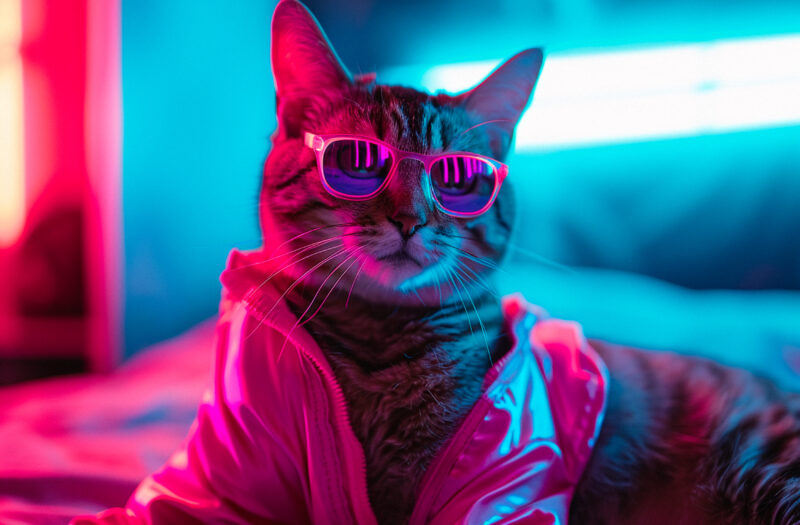

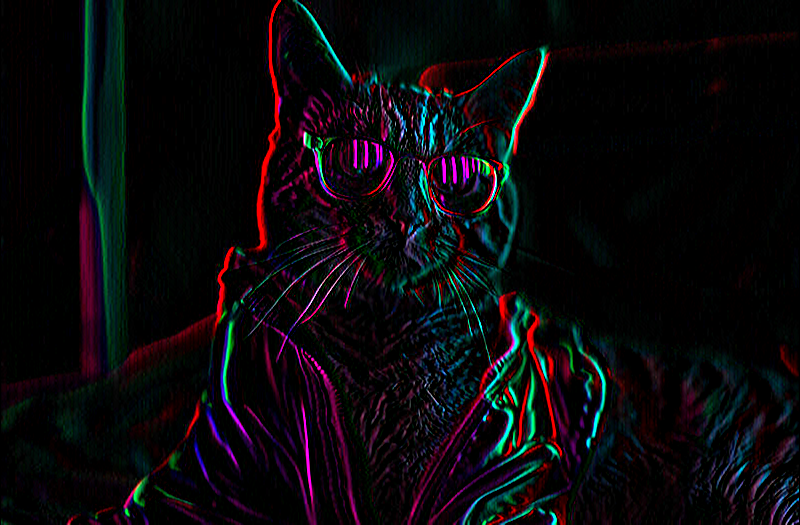

In [ ]:
#Testing on custom images
from PIL import Image

image = Image.open('sampleq2.jpg')
input_np = np.array(image)
display(image)

#Defiining a sobel kernel for horizontal edge detection
sobel_filter = np.array([[-1,0,1],
                       [-2,0,2],
                       [-1,0,1]])

#Apply the filter
filtered_img = filt(input_np, sobel_filter, padding=True, normalization=False)

#Convert back to image and save
filtered_image = Image.fromarray(filtered_img.astype('uint8'))
filtered_image.save('filtered_sample1.jpg')
display(filtered_image)

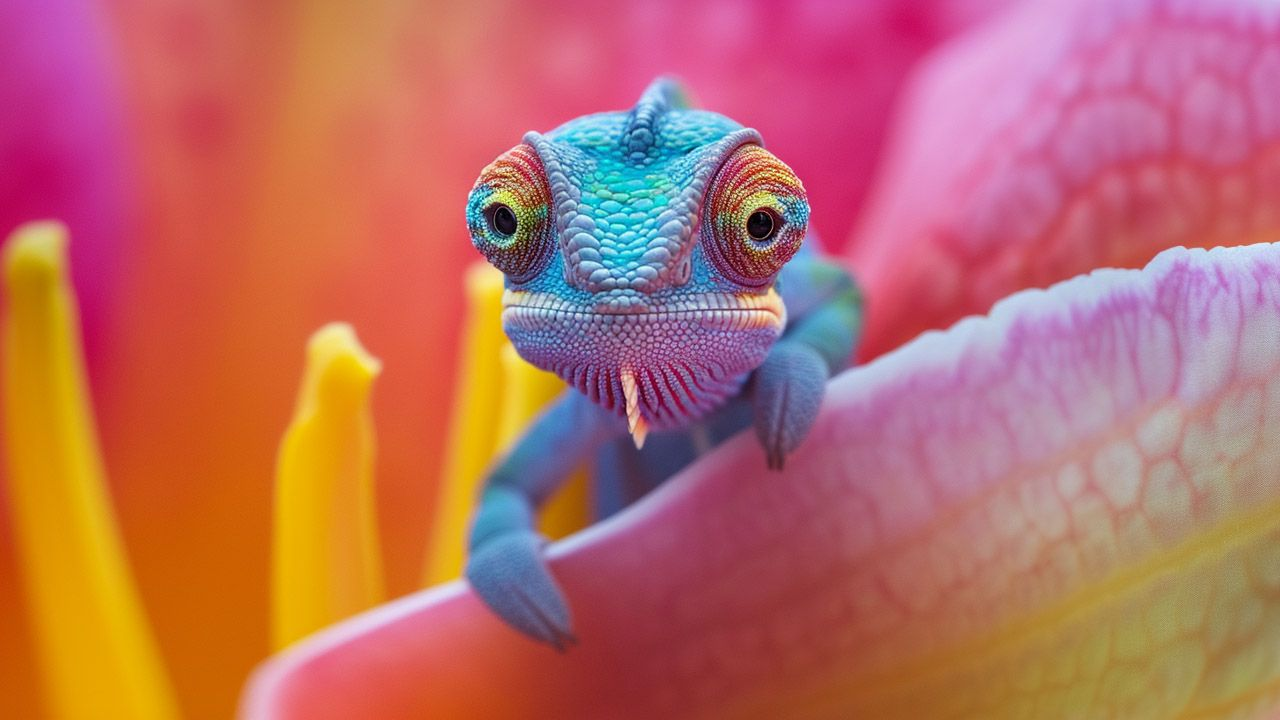

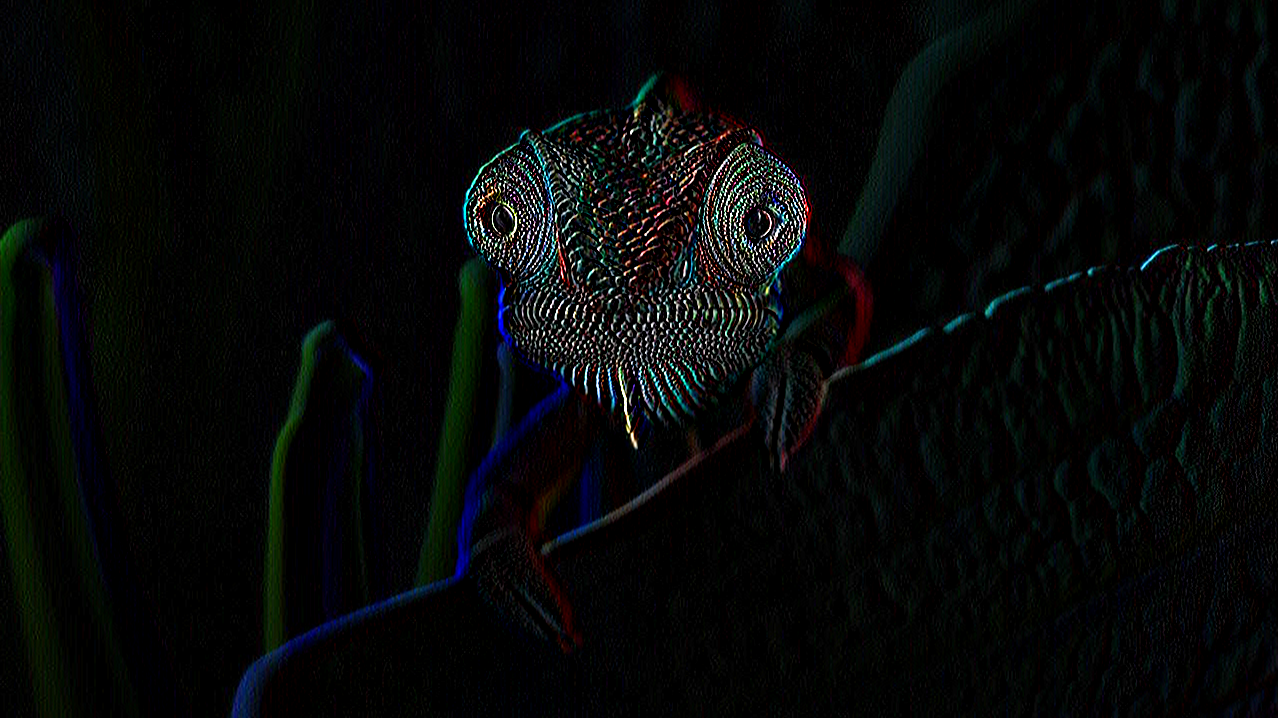

In [ ]:
image = Image.open('sample2q2.jpg')
input_np = np.array(image)
display(image)

#Defiining a sobel kernel for horizontal edge detection
sobel_filter = np.array([[-1,0,1],
                       [-2,0,2],
                       [-1,0,1]])

#Apply the filter
filtered_img = filt(input_np, sobel_filter, padding=False, normalization=False)

#Convert back to image and save
filtered_image = Image.fromarray(filtered_img.astype('uint8'))
filtered_image.save('filtered_sample1.jpg')
display(filtered_image)

# Question 3

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import drive

train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'

#Extracting HOG features using scikit-image lib
def extract_hog_features(image):
    resized_img = cv2.resize(image, (128, 128))
    gray_image = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    hog_features, _ = hog(
        gray_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2',
        visualize=True
    )
    return hog_features

#Loading the train images and extracting the features
X_train, y_train = [], []
for label, category in enumerate(os.listdir(train_dir)):
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = cv2.imread(img_path)
        features = extract_hog_features(image)
        X_train.append(features)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

#Loading the test images and extracting the features
X_test, y_test = [], []
for label, category in enumerate(os.listdir(test_dir)):
    category_path = os.path.join(test_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = cv2.imread(img_path)
        features = extract_hog_features(image)
        X_test.append(features)
        y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Training a Linear SVM on the entire training set
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

#Evaluate the model on the test set
y_pred = svm.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 64.93%
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       510
           1       0.71      0.69      0.70       437
           2       0.49      0.48      0.48       525
           3       0.82      0.91      0.86       474
           4       0.79      0.70      0.74       501
           5       0.56      0.52      0.54       553

    accuracy                           0.65      3000
   macro avg       0.66      0.66      0.65      3000
weighted avg       0.65      0.65      0.65      3000

Confusion Matrix:
[[325  16 100   8   2  59]
 [ 27 300  10   7  70  23]
 [121  13 253  11   4 123]
 [  5  11   5 432  14   7]
 [ 19  74   4  43 353   8]
 [ 82   8 148  24   6 285]]


# Question 4

Please note that in below part I have utilised the Fashion MNIST testing
data as my validation data.

## Part a

Using device: cuda
FeedforwardNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=256, out_features=10, bias=True)
)
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,)

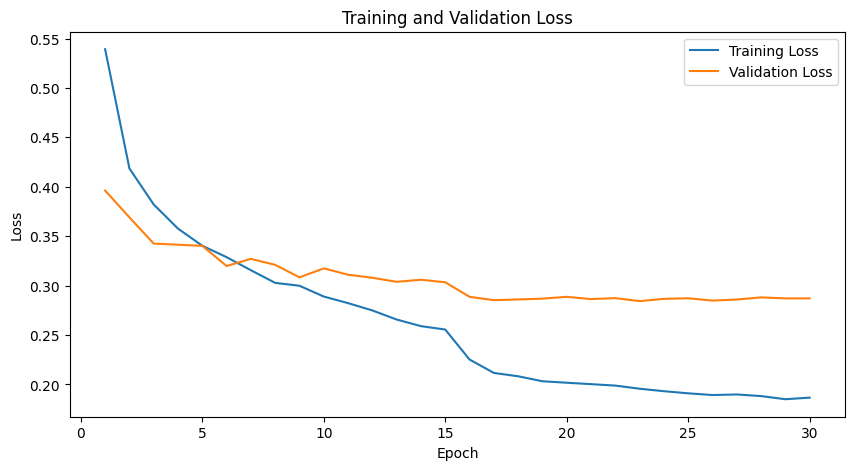

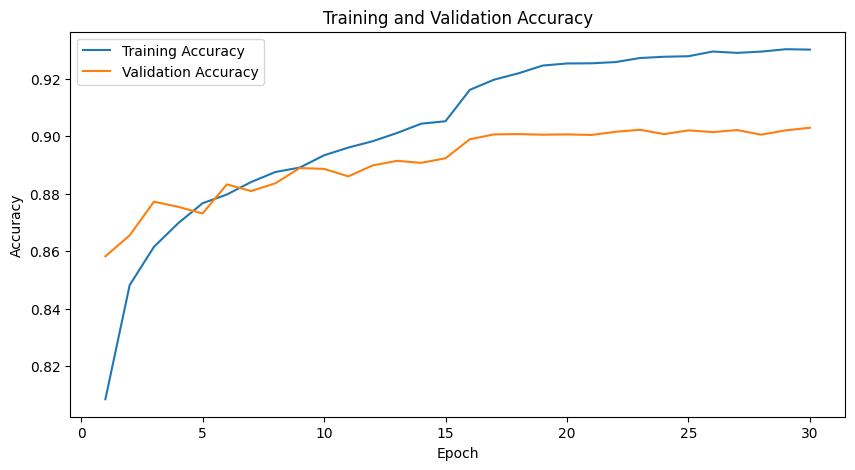

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#Checking for GPU availability (got this idea off of intenet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

#Hyperparameters
input_size = 28*28  #Fashion MNIST images are 28x28 pixels
hidden_sizes = [256, 256, 256]  #Using three hidden layers of size 256
num_classes = 10  #Number of classes in Fashion MNIST
learning_rate = 0.001  #Learning rate for the optimizer
batch_size = 64  #Number of samples per batch
num_epochs = 30  #Number of epochs to train
dropout_prob = 0.3  #Dropout probability for regularization

#Creating a Feedforward Neural Network Architecture
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob):
        super(FeedforwardNN, self).__init__()

        #Flatten layer to convert each 28x28 image into a 784-dimensional vector
        self.flatten = nn.Flatten()

        #Adding fully connected layers with ReLU activation along with dropout layer for regularization
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])  #Add batch normalization layers after each FC layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_prob)

        #Output layer producing logits for each class
        self.output = nn.Linear(hidden_sizes[2], num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.output(x)
        return x

model = FeedforwardNN(input_size, hidden_sizes, num_classes, dropout_prob).to(device)
print(model)

#Now defining the necessary transformations for preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#Loading the training and testing datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(train_dataset)
print(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  #Shuffle training data
validation_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #Validation data is not shuffled

#CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

#Using Adam optimizer to optimize the param wrt LR
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#Adding learning rate scheudler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches of training data
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        optimizer.zero_grad()  #Zero gradients from previous iteration
        loss.backward()        #Backpropagate the loss
        optimizer.step()       #Update model parameters

        _, predicted = torch.max(outputs.data, 1)  #Predicted class with max logit
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * images.size(0)

    #Calculating average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    #Step down learning rate
    scheduler.step()

    #Now validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    #Disable gradient calculation for validation to test
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            #Forward pass for validation
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            #Computing acc
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    #Calculating average validation loss and accuracy for this epoch
    val_epoch_loss = val_loss / len(validation_loader.dataset)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {epoch_loss:.4f} '
          f'Train Acc: {epoch_acc*100:.2f}% '
          f'Val Loss: {val_epoch_loss:.4f} '
          f'Val Acc: {val_epoch_acc*100:.2f}%')

print(f'\nFinal Training Accuracy: {train_accuracies[-1]*100:.2f}%')
print(f'Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%')

#Plotting the loss curves for both training and validation over all epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the accuracy curves for both training and validation over all epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

I experimented with various hyperparameter adjustments, including modifying the architecture, batch size, and dropout rate. Initially, using two hidden layers (256 and 128 neurons), a batch size of 64, and a dropout rate of 0.2 resulted in an accuracy of approximately 88.5%. I then increased the batch size to 128 and adjusted the dropout rate to 0.3, which, along with two hidden layers of 256 neurons each and a step learning rate, raised the accuracy to 89.6%. Further trials included reducing epochs to 20 with a dropout rate of 0.4, yielding 88.8%. Finally, adding an additional hidden layer with three layers of 256 neurons each and 30 epochs and adding batch normalization after each FC layer, increased accuracy to around 90.3%, indicating a positive impact from the deeper architecture and adjusted regularization.

## Part b

Using device: cuda
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

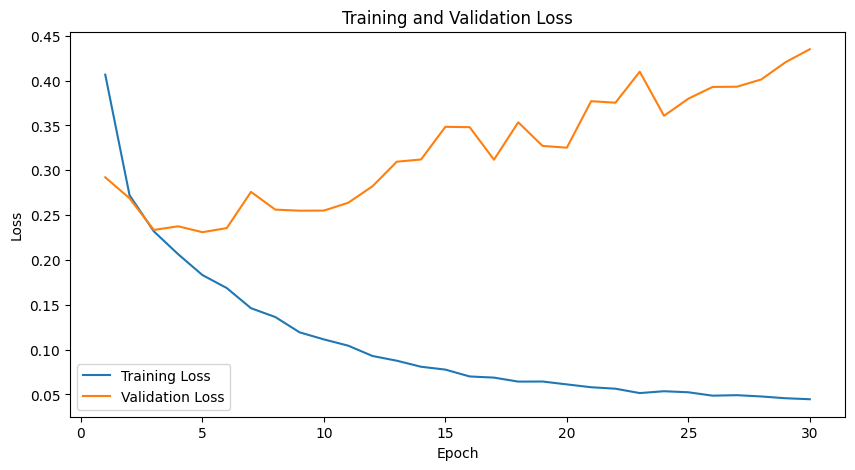

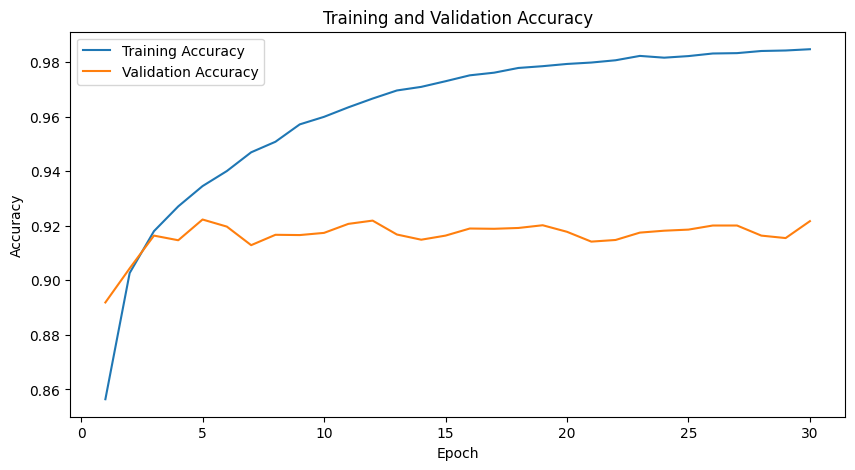

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#Checking for GPU availability (got this idea off of intenet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

#Hyperparameters
num_classes = 10  #Number of classes in Fashion MNIST
learning_rate = 0.001  #Learning rate for the optimizer
batch_size = 32  #Number of samples per batch
num_epochs = 30  #Number of epochs to train
dropout_prob = 0.35  #Dropout probability for regularization


#Defining the CNN Architecture
class CNN(nn.Module):
    def __init__(self, dropout_prob):
        super(CNN, self).__init__()

        #Applying convolutional layer (input channels, output channels, kernel size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  #Batch normalization layer
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  #To reduce dimensions

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Fully connected layers at the end
        self.fc1 = nn.Linear(256 * 1 * 1, 128)  #Adjusted for output size
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(128, num_classes)  #Final output layer for classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        #Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        #Fully connected layers
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

model = CNN(dropout_prob).to(device)
print(model)

#Now defining the necessary transformations for preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#Loading the training and testing datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(train_dataset)
print(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  #Shuffle training data
validation_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #Validation data is not shuffled

#CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

#Using Adam optimizer to optimize the param wrt LR
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)  #Adds L2 regularization

#Learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  #Reduce LR by half every 10 epochs

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches of training data
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        optimizer.zero_grad()  #Zero gradients from previous iteration
        loss.backward()        #Backpropagate the loss
        optimizer.step()       #Update model parameters

        _, predicted = torch.max(outputs.data, 1)  #Predicted class with max logit
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * images.size(0)

    #Calculating average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    #Now validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    #Disable gradient calculation for validation to test
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            #Forward pass for validation
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            #Computing acc
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    #Calculating average validation loss and accuracy for this epoch
    val_epoch_loss = val_loss / len(validation_loader.dataset)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    #Stepping the LR
    scheduler.step(val_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {epoch_loss:.4f} '
          f'Train Acc: {epoch_acc*100:.2f}% '
          f'Val Loss: {val_epoch_loss:.4f} '
          f'Val Acc: {val_epoch_acc*100:.2f}%')

print(f'\nFinal Training Accuracy: {train_accuracies[-1]*100:.2f}%')
print(f'Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%')

#Plotting the loss curves for both training and validation over all epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot the accuracy curves for both training and validation over all epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

To achieve higher accuracy on the Fashion MNIST dataset, I experimented with various hyperparameter settings. Initially, I used a batch size of 64, dropout rate of 0.4, and basic augmentations, achieving an accuracy of 91.2%. I then increased the batch size to 128 and dropout to 0.5, which reduced overfitting but yielded a slightly lower accuracy of 88.7%. Finally, I implemented more refined tuning: I lowered the learning rate to 0.0005 with a scheduler, reduced the rotation in augmentations, added a third convolutional layer for deeper feature extraction and applied L2 regularization with weight_decay=1e-4. It still didnt get the desired accuracy, so I added another FC layer, and tweaked the batch size to 32 which made the process a bit slower (a lot slower actually but I utlisied colab GPU for it) and increased noise and helps come out of the local minima. I also added conditional dropout such that for first 15 epochs the dropout prob is 0.5 and for the next 15, it's 0.3. After everything, I resorted to more simpler approach and reduced the dropout prob to 0.3 in all epochs (as that worked for me in part a), and I removed the data augmentation I had added earlier as I feel like the test set doesn't need the augmented data. It performs much better on just normal data. I also added a fourth convolution layer as well. After all this, I got 92%+ accuracy. While I feel like the training accuracy is very high compared to test accuracy, this means that model is overfitting and can perform even better. However I dont have resources left to train it again.

## Part c

Using device: cuda
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Epoch [1/5], Train Loss: 0.4157, Train Acc: 85.73% Val Loss: 0.2843, Val Acc: 89.68%
Epoch [2/5], Train Loss: 0.3216, Train Acc: 88.92% Val Loss: 0.2917, Val Acc: 89.57%
Epoch [3/5], Train Loss: 0.2957, Train

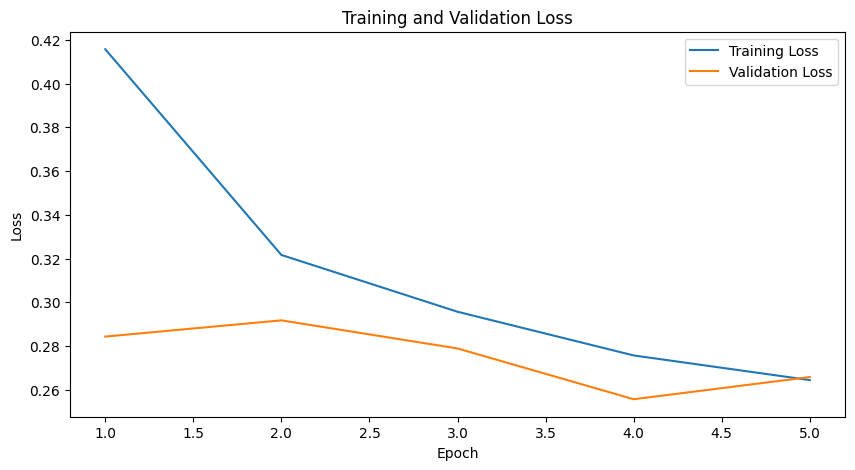

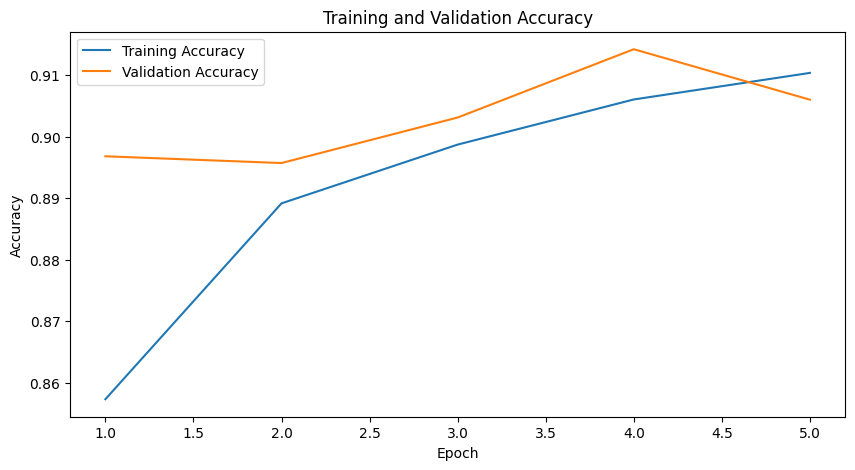

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#Checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

#Hyperparameters
num_classes = 10  # Number of classes in Fashion MNIST
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 64  # Number of samples per batch
num_epochs = 5  # Number of epochs to train
dropout_prob = 0.5  # Dropout probability for regularization

#Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  #Resize to VGG-16 expected input size
    transforms.Grayscale(num_output_channels=3),  #Convert 1-channel grayscale to 3-channel as VGG-16 expects
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #Normalize with 3 channels
])

#Loading Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(train_dataset)
print(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  #Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #Validation data is not shuffled

#Loading the pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

#Freezing all convolutional layers of VGG-16
for param in vgg16.features.parameters():
    param.requires_grad = False

#Define a new classifier network to attach on top of VGG-16's features
class VGG16_FashionMNIST(nn.Module):
    def __init__(self, vgg16, num_classes, dropout_prob):
        super(VGG16_FashionMNIST, self).__init__()
        self.features = vgg16.features  #Use VGG-16 as a feature extractor
        self.classifier = nn.Sequential(
            nn.Linear(8192, 4096),  #Input size based on VGG-16 output for 224x224
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(4096, 1024),  #Intermediate layer for complexity
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(1024, num_classes)  #Output layer for 10 classes
        )

    def forward(self, x):
        x = self.features(x)  #Extract features using VGG-16 layers
        x = x.view(x.size(0), -1)  #Flatten the output for the fully connected layers
        x = self.classifier(x)  #Pass through the classifier
        return x

#Move model to device (GPU or CPU)
model = VGG16_FashionMNIST(vgg16, num_classes, dropout_prob).to(device)

#CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

#Using Adam optimizer to optimize the classifier only
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

#Training and evaluation loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    #Iterate over batches of training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        optimizer.zero_grad()  #Zero gradients from previous iteration
        loss.backward()        #Backpropagate the loss
        optimizer.step()       #Update model parameters

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)  #Predicted class with max logit
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    #Calculating average loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    #Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    #Disable gradient calculation for validation to test
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            #Forward pass for validation
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    #Calculating average validation loss and accuracy for this epoch
    val_loss /= len(test_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

#Plotting the loss and accuracy curves for both training and validation
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Since the dataset images are grayscale, I converted them to three channels to match VGG-16’s expected input format. I first went with the usual 224x224 images, but that was taking too long to run so I resized the images to 128x128 which helps speed up training and reduces memory usage while still preserving enough detail. The convolutional layers in VGG-16 are kept frozen to retain the features it learned from ImageNet, and I added a custom fully connected classifier on top to fine-tune for Fashion MNIST’s 10 classes. This setup combines the powerful, pre-trained features from VGG-16 with a specific classifier tailored to our task, achieving both efficiency and accuracy.